# CROHME 2019 Dataset – Exploratory Data Analysis

This notebook explores the CROHME 2019 handwritten mathematical expression dataset by summarising the LaTeX annotations and analysing the structure of the accompanying InkML stroke data.


## Objectives

- Summarise the number of expressions contained in the CROHME 2019 train/validation/test splits.

- Analyse LaTeX token sequences: expression length distribution and most frequent symbols.

- Sample InkML files to inspect stroke statistics (strokes per expression, points per stroke, bounding boxes).

- Surface representative examples for quick qualitative understanding.


## Environment Setup

In [2]:
import sys

from pathlib import Path

import json

import random

import xml.etree.ElementTree as ET

from collections import Counter



import numpy as np

import pandas as pd

import matplotlib.pyplot as plt



plt.style.use('seaborn-v0_8')

random.seed(42)



NOTEBOOK_DIR = Path(__file__).resolve().parent if '__file__' in globals() else Path.cwd()

PROJECT_ROOT = NOTEBOOK_DIR.parent

if str(PROJECT_ROOT) not in sys.path:

    sys.path.append(str(PROJECT_ROOT))



DATA_DIR = NOTEBOOK_DIR / 'CROHME'

assert DATA_DIR.exists(), f"Expected to find CROHME directory at {DATA_DIR}"



SPLIT_FILES = {

    'train': DATA_DIR / 'crohme2019_train.txt',

    'valid': DATA_DIR / 'crohme2019_valid.txt',

    'test': DATA_DIR / 'crohme2019_test.txt',

}



for split_name, split_path in SPLIT_FILES.items():

    assert split_path.exists(), f"Missing {split_name} list: {split_path}"

split_paths = pd.Series({name: path for name, path in SPLIT_FILES.items()})

split_paths

train    d:\projectDAT\image-computer\new_process\Data\...
valid    d:\projectDAT\image-computer\new_process\Data\...
test     d:\projectDAT\image-computer\new_process\Data\...
dtype: object

## Load CROHME 2019 annotation splits

In [3]:
def load_split(split_name: str, split_path: Path) -> pd.DataFrame:

    df = pd.read_csv(

        split_path,

        sep='\t',

        header=None,

        names=['inkml_rel_path', 'latex_raw'],

        engine='python',

        quoting=3,

        encoding='utf-8',

        on_bad_lines='warn',

    )

    df['split'] = split_name

    df['latex_raw'] = df['latex_raw'].fillna('').astype(str)

    df['latex_tokens'] = df['latex_raw'].apply(lambda s: s.strip().split() if s else [])

    df['num_tokens'] = df['latex_tokens'].str.len()

    return df





splits = [load_split(name, path) for name, path in SPLIT_FILES.items()]

annotations = pd.concat(splits, ignore_index=True)

annotations.sample(5, random_state=42)

,inkml_rel_path,latex_raw,split,latex_tokens,num_tokens
5421,crohme2019/train/2009212-1031-72.inkml,- Right 6,train,"[-, Right, 6]",3
4228,crohme2019/train/TrainData2_9_sub_20.inkml,a Right + Right b Right + Right c Right + Righ...,train,"[a, Right, +, Right, b, Right, +, Right, c, Ri...",17
10024,crohme2019/test/UN19_1028_em_398.inkml,x Sub 1 NoRel + Right i Right x Sub 2 NoRel = ...,test,"[x, Sub, 1, NoRel, +, Right, i, Right, x, Sub,...",33
7731,crohme2019/train/200924-1312-257.inkml,\sin Sup p NoRel P,train,"[\sin, Sup, p, NoRel, P]",5
6832,crohme2019/train/200923-1251-146.inkml,r NoRel - Below P,train,"[r, NoRel, -, Below, P]",5


## Dataset overview

In [4]:
def describe_split(df: pd.DataFrame) -> pd.DataFrame:

    grouped = df.groupby('split').agg(

        expressions=('inkml_rel_path', 'count'),

        avg_tokens=('num_tokens', 'mean'),

        median_tokens=('num_tokens', 'median'),

        max_tokens=('num_tokens', 'max'),

        min_tokens=('num_tokens', 'min'),

    )

    grouped['avg_tokens'] = grouped['avg_tokens'].round(2)

    return grouped





split_summary = describe_split(annotations)

split_summary

,expressions,avg_tokens,median_tokens,max_tokens,min_tokens
split,,,,,
test,1199,19.91,17.0,91,0
train,8900,18.57,15.0,133,1
valid,986,19.32,17.0,189,1


## Expression length distribution

In [5]:
quantiles = annotations.groupby('split')['num_tokens'].quantile([0.1, 0.25, 0.5, 0.75, 0.9]).unstack()

quantiles.rename(columns={0.1: 'p10', 0.25: 'p25', 0.5: 'p50', 0.75: 'p75', 0.9: 'p90'})


,p10,p25,p50,p75,p90
split,,,,,
test,5.0,9.0,17.0,27.0,37.0
train,3.0,7.0,15.0,25.0,37.0
valid,5.0,7.0,17.0,25.0,37.0


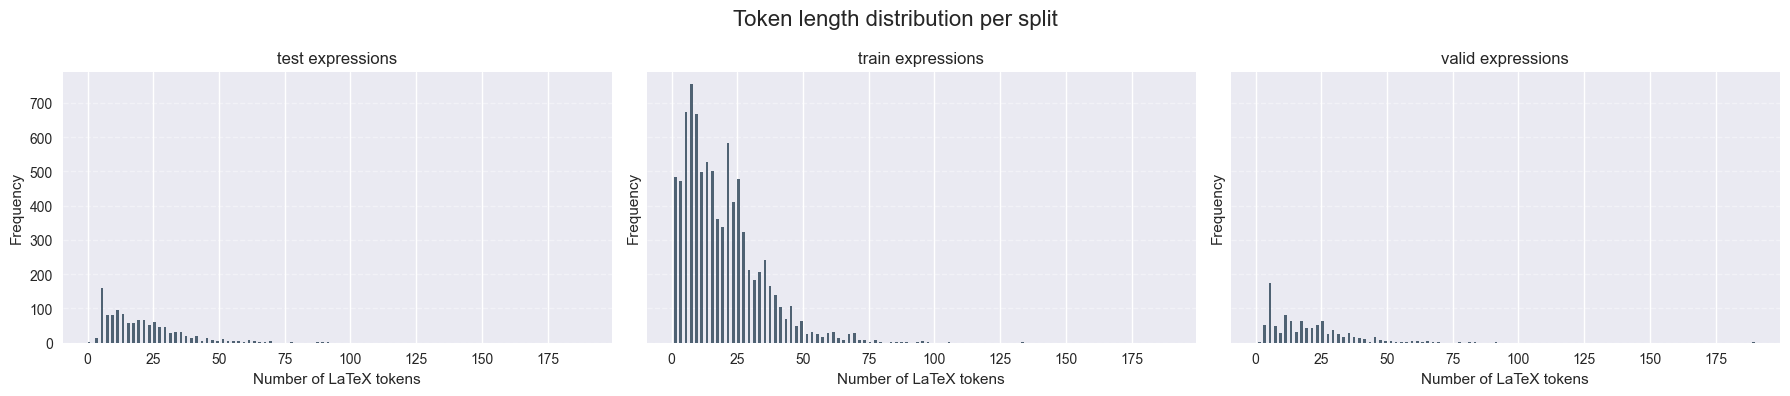

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

bins = np.arange(0, annotations['num_tokens'].max() + 2)



for ax, (split_name, subset) in zip(axes, annotations.groupby('split')):

    ax.hist(subset['num_tokens'], bins=bins, color='#284054', alpha=0.8)

    ax.set_title(f"{split_name} expressions")

    ax.set_xlabel('Number of LaTeX tokens')

    ax.set_ylabel('Frequency')

    ax.grid(True, axis='y', linestyle='--', alpha=0.4)



fig.suptitle('Token length distribution per split', fontsize=16)

plt.tight_layout()

plt.show()


## Symbol vocabulary analysis

In [14]:
def token_frequencies(df: pd.DataFrame, top_k: int = 25) -> pd.DataFrame:

    counter = Counter()

    for tokens in df['latex_tokens']:

        counter.update(tokens)

    most_common = counter.most_common(top_k)

    return pd.DataFrame(most_common, columns=['token', 'frequency']).set_index('token')


top_tokens_overall = token_frequencies(annotations,200)

# top_tokens_overall
top_tokens_overall.to_csv('top_tokens_overall.csv')

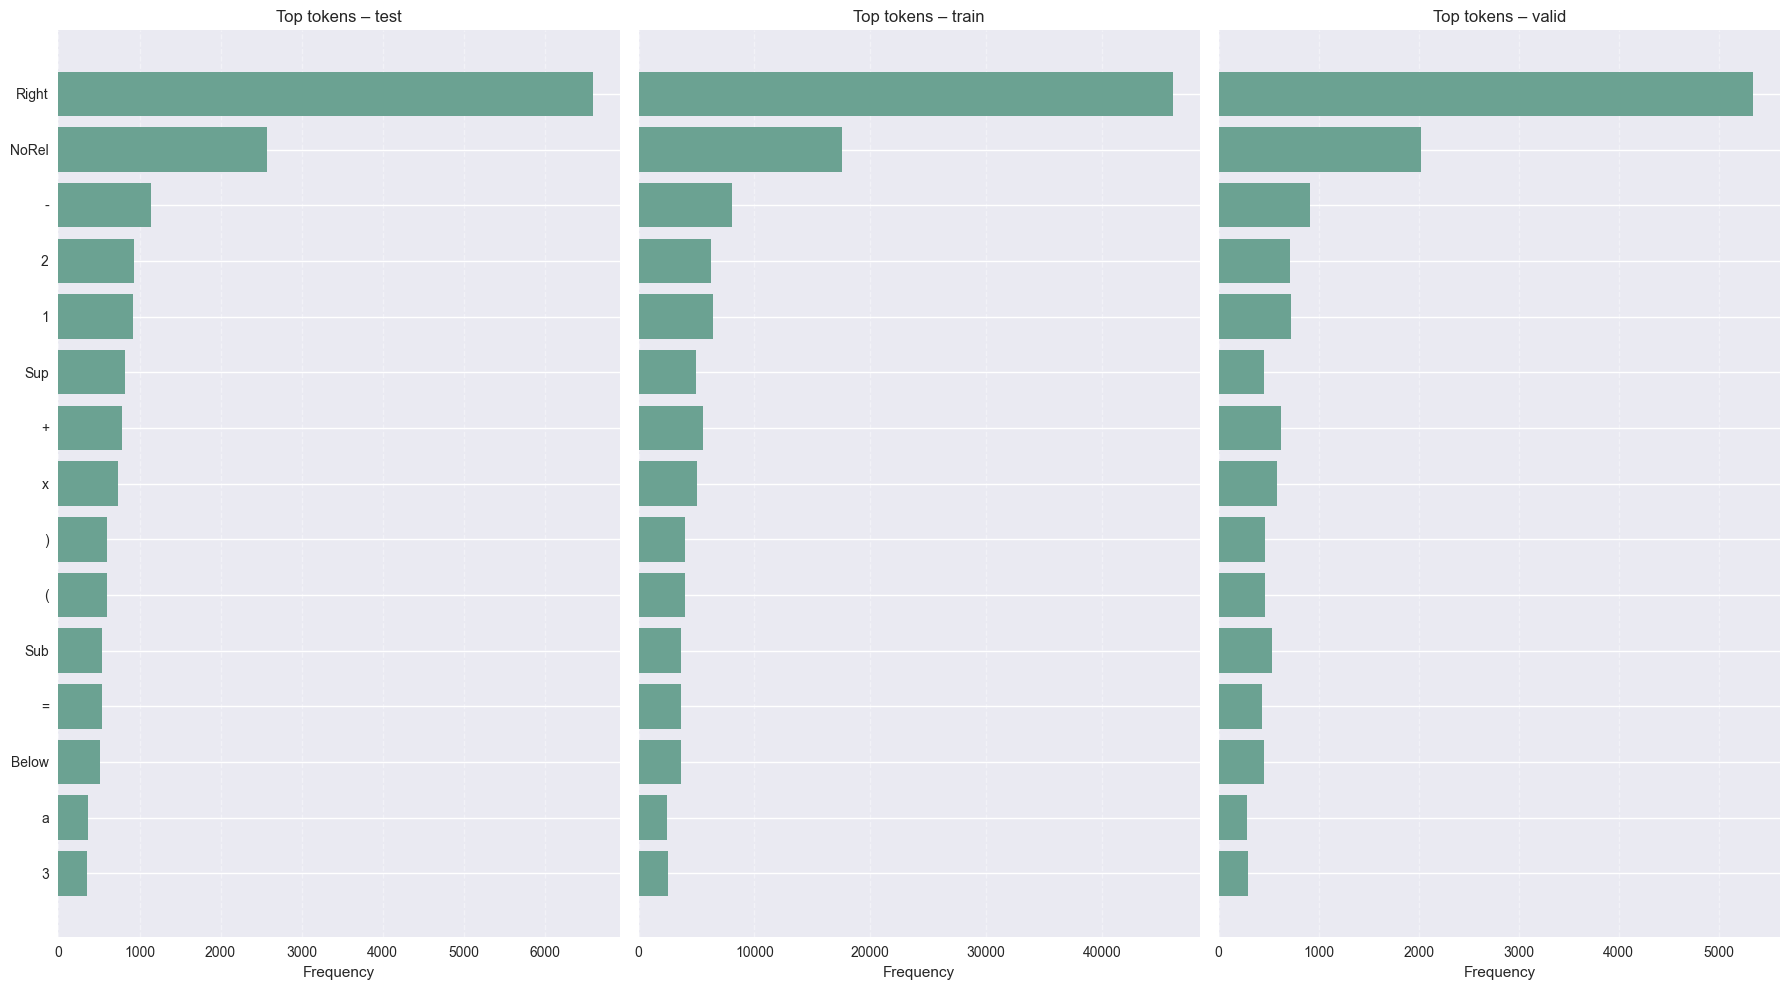

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 10), sharey=True)

for ax, (split_name, subset) in zip(axes, annotations.groupby('split')):

    top_tokens = token_frequencies(subset, top_k=15)

    ax.barh(top_tokens.index[::-1], top_tokens['frequency'][::-1], color='#6ba292')

    ax.set_title(f"Top tokens – {split_name}")

    ax.set_xlabel('Frequency')

    ax.grid(True, axis='x', linestyle='--', alpha=0.4)



plt.tight_layout()

plt.show()


## InkML stroke statistics

In [23]:
INKML_BASES = [

    DATA_DIR,

    DATA_DIR / 'crohme2019',

    DATA_DIR / 'crohme2019' / 'crohme2019',

]

INKML_BASES = [base for base in INKML_BASES if base.exists()]



INKML_NAMESPACE = '{http://www.w3.org/2003/InkML}'





def resolve_inkml_path(rel_path: str) -> Path:

    rel = Path(rel_path)

    for base in INKML_BASES:

        candidate = base / rel

        if candidate.exists():

            return candidate

    raise FileNotFoundError(f"Could not locate InkML file for {rel_path}")





def parse_inkml_metadata(inkml_path: Path) -> dict:

    tree = ET.parse(inkml_path)

    root = tree.getroot()

    traces = root.findall(f'{INKML_NAMESPACE}trace')

    num_traces = len(traces)

    points_per_trace = []

    xs, ys = [], []



    for trace in traces:

        coords = []

        if trace.text:

            raw_points = trace.text.replace('\n', '').split(',')

            for raw_point in raw_points:

                raw_point = raw_point.strip()

                if not raw_point:

                    continue

                axis_vals = [val for val in raw_point.split(' ') if val]

                if len(axis_vals) < 2:

                    continue

                x, y = map(float, axis_vals[:2])

                xs.append(x)

                ys.append(y)

                coords.append((x, y))

        points_per_trace.append(len(coords))



    total_points = sum(points_per_trace)

    width = (max(xs) - min(xs)) if xs else 0.0

    height = (max(ys) - min(ys)) if ys else 0.0



    return {

        'num_traces': num_traces,

        'total_points': total_points,

        'mean_points_per_trace': float(np.mean(points_per_trace)) if points_per_trace else 0.0,

        'median_points_per_trace': float(np.median(points_per_trace)) if points_per_trace else 0.0,

        'std_points_per_trace': float(np.std(points_per_trace)) if points_per_trace else 0.0,

        'width': width,

        'height': height,

    }





def collect_inkml_stats(df: pd.DataFrame, sample_per_split: int = 200) -> pd.DataFrame:

    records = []

    for split_name, subset in df.groupby('split'):

        sample_size = min(sample_per_split, len(subset))

        sampled_rows = subset.sample(sample_size, random_state=42)

        for _, row in sampled_rows.iterrows():

            inkml_path = resolve_inkml_path(row['inkml_rel_path'])

            stats = parse_inkml_metadata(inkml_path)

            stats.update({'split': split_name, 'inkml_path': str(inkml_path)})

            records.append(stats)

    return pd.DataFrame.from_records(records)





inkml_stats = collect_inkml_stats(annotations)

inkml_stats.head()

,num_traces,total_points,mean_points_per_trace,median_points_per_trace,std_points_per_trace,width,height,split,inkml_path
0,18,793,44.055556,32.5,34.296861,1030.0,257.0,test,c:\Users\Bao Viet\Desktop\FPT University\FALL ...
1,23,666,28.956522,18.0,20.592270,1064.0,175.0,test,c:\Users\Bao Viet\Desktop\FPT University\FALL ...
2,26,515,19.807692,18.5,9.499066,786.0,101.0,test,c:\Users\Bao Viet\Desktop\FPT University\FALL ...
3,16,577,36.062500,32.5,17.140846,767.0,169.0,test,c:\Users\Bao Viet\Desktop\FPT University\FALL ...
4,19,382,20.105263,15.0,13.995844,586.0,158.0,test,c:\Users\Bao Viet\Desktop\FPT University\FALL ...


### Distribution summaries

In [25]:
inkml_summary = inkml_stats.groupby('split').agg(

    samples=('inkml_path', 'count'),

    avg_traces=('num_traces', 'mean'),

    median_traces=('num_traces', 'median'),

    max_traces=('num_traces', 'max'),

    avg_width=('width', 'mean'),

    avg_height=('height', 'mean'),

)

inkml_summary.round(2)

,samples,avg_traces,median_traces,max_traces,avg_width,avg_height
split,,,,,,
test,200,14.30,13.0,40,560.32,152.98
train,200,13.89,13.0,53,2439.63,997.54
valid,200,13.25,12.0,60,511.52,163.96


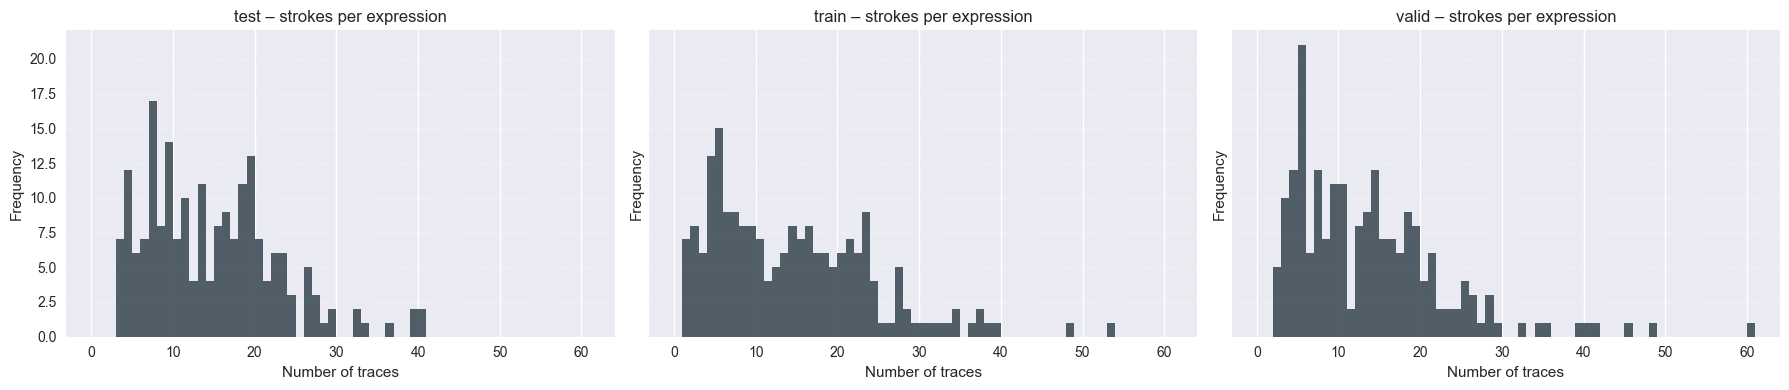

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

bins = np.arange(0, inkml_stats['num_traces'].max() + 2)

for ax, (split_name, subset) in zip(axes, inkml_stats.groupby('split')):

    ax.hist(subset['num_traces'], bins=bins, color='#36454F', alpha=0.85)

    ax.set_title(f"{split_name} – strokes per expression")

    ax.set_xlabel('Number of traces')

    ax.set_ylabel('Frequency')

    ax.grid(True, axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()

plt.show()


In [30]:
annotations_with_paths = annotations.copy()

annotations_with_paths['inkml_abs_path'] = annotations_with_paths['inkml_rel_path'].apply(lambda p: str(resolve_inkml_path(p)))



inkml_with_tokens = inkml_stats.merge(

    annotations_with_paths[['inkml_abs_path', 'num_tokens']],

    left_on='inkml_path',

    right_on='inkml_abs_path',

    how='left'

)

inkml_with_tokens.head()

,num_traces,total_points,mean_points_per_trace,median_points_per_trace,std_points_per_trace,width,height,split,inkml_path,inkml_abs_path,num_tokens
0,18,793,44.055556,32.5,34.296861,1030.0,257.0,test,c:\Users\Bao Viet\Desktop\FPT University\FALL ...,c:\Users\Bao Viet\Desktop\FPT University\FALL ...,25
1,23,666,28.956522,18.0,20.592270,1064.0,175.0,test,c:\Users\Bao Viet\Desktop\FPT University\FALL ...,c:\Users\Bao Viet\Desktop\FPT University\FALL ...,35
2,26,515,19.807692,18.5,9.499066,786.0,101.0,test,c:\Users\Bao Viet\Desktop\FPT University\FALL ...,c:\Users\Bao Viet\Desktop\FPT University\FALL ...,43
3,16,577,36.062500,32.5,17.140846,767.0,169.0,test,c:\Users\Bao Viet\Desktop\FPT University\FALL ...,c:\Users\Bao Viet\Desktop\FPT University\FALL ...,27
4,19,382,20.105263,15.0,13.995844,586.0,158.0,test,c:\Users\Bao Viet\Desktop\FPT University\FALL ...,c:\Users\Bao Viet\Desktop\FPT University\FALL ...,23


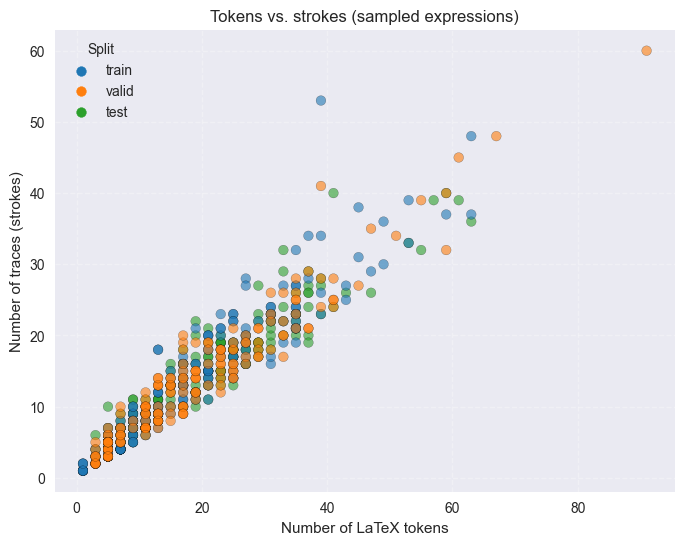

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))

scatter = ax.scatter(

    inkml_with_tokens['num_tokens'],

    inkml_with_tokens['num_traces'],

    c=inkml_with_tokens['split'].map({'train': '#1f77b4', 'valid': '#ff7f0e', 'test': '#2ca02c'}),

    alpha=0.6,

    edgecolor='k',

    linewidth=0.2,

)

ax.set_xlabel('Number of LaTeX tokens')

ax.set_ylabel('Number of traces (strokes)')

ax.set_title('Tokens vs. strokes (sampled expressions)')



for split_name, color in [('train', '#1f77b4'), ('valid', '#ff7f0e'), ('test', '#2ca02c')]:

    ax.scatter([], [], c=color, label=split_name)

ax.legend(title='Split')

ax.grid(True, linestyle='--', alpha=0.3)

plt.show()


## Sample expressions and annotations

In [1]:
def clean_token_sequence(tokens):

    """Collapse CROHME spatial relationship markers to improve readability."""

    rel_markers = {

        'Right', 'NoRel', 'Above', 'Below', 'Inside', 'Sup', 'Sub',

        'COMMA', 'Left', 'Right', 'Up', 'Down'

    }

    filtered = [tok for tok in tokens if tok not in rel_markers]

    return ' '.join(filtered)





sample_df = annotations.sample(5, random_state=123).copy()

sample_df['clean_latex'] = sample_df['latex_tokens'].apply(clean_token_sequence)

sample_view = sample_df[['split', 'inkml_rel_path', 'num_tokens', 'clean_latex']]

sample_view

NameError: name 'annotations' is not defined

## Key takeaways

- Token lengths vary widely across splits; histograms highlight heavier tails in the train set.

- Frequent tokens are dominated by structural markers (`Right`, `NoRel`) and layout operators, suggesting strong spatial annotation usage.

- Sampled InkML statistics show typical expressions use only a handful of traces but some exceed 30+, informing model capacity planning.

- Strokes and LaTeX token counts are positively correlated yet noisy, indicating models must handle variable stroke-to-token ratios.


## InkML → image previews

In [37]:
from inkml2img import inkml2img

from IPython.display import display, Image

import tempfile



preview_records = []

attempts = 0

target_samples = 3



while len(preview_records) < target_samples and attempts < len(inkml_with_tokens):

    row = inkml_with_tokens.sample(1, random_state=2024 + attempts).iloc[0]

    attempts += 1

    inkml_path = Path(row['inkml_abs_path'])



    try:

        with tempfile.NamedTemporaryFile(suffix='.png', delete=False) as tmp:

            inkml2img(str(inkml_path), tmp.name)



            latex_raw_val = row.get('latex_raw') if hasattr(row, 'get') else None

            latex_tokens_val = row.get('latex_tokens') if hasattr(row, 'get') else None



            if isinstance(latex_raw_val, str) and latex_raw_val:

                latex_repr = latex_raw_val

            elif isinstance(latex_tokens_val, (list, tuple)):

                latex_repr = ' '.join(latex_tokens_val)

            else:

                latex_repr = ''



            preview_records.append({

                'split': row['split'],

                'inkml': inkml_path.name,

                'latex_string': latex_repr,

                'image_path': tmp.name,

            })

    except Exception as exc:

        print(f"Skipping {inkml_path.name}: {exc}")

        continue



preview_df = pd.DataFrame(preview_records)

preview_df[['split', 'inkml', 'latex_string']]

,split,inkml,latex_string
0,valid,512_em_294.inkml,
1,valid,35_em_22.inkml,
2,valid,37_em_22.inkml,


<Figure size 800x550 with 0 Axes>

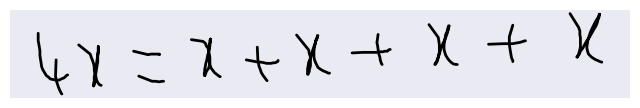

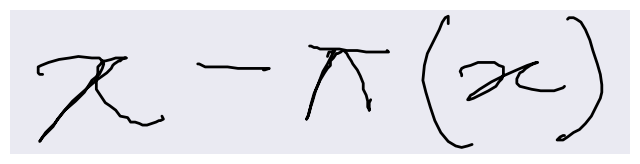

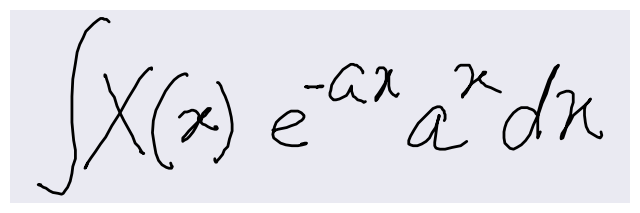

In [38]:
for _, row in preview_df.iterrows():

    display(Image(filename=row['image_path']))



In [ ]:
a = [818,443,915,673,745,238,697,115,492,725,557,563,055,250,793,]

In [1]:
for i in range(0,18,5):
    print(i)

0
5
10
15
